In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse

# Import data
from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf

FLAGS = None

mnist = input_data.read_data_sets('./data/MNIST', one_hot=True)

Extracting ./data/MNIST/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/t10k-labels-idx1-ubyte.gz


In [19]:
images, labels = mnist.train.next_batch(10)

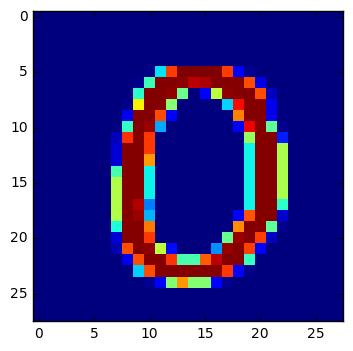

In [45]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.reshape(images[0], (28, 28)), interpolation='nearest')
plt.show()


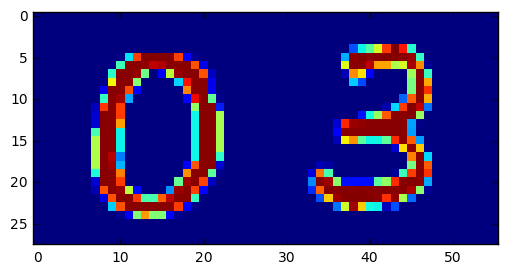

[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.]
(28, 56)


In [49]:
result = np.concatenate((np.reshape(images[0], (28, 28)), np.reshape(images[1], (28, 28))), axis = 1)
result_label = np.concatenate((labels[0], labels[1]), axis = 0)
plt.imshow(result, interpolation='nearest')
plt.show()
print (result_label)
print (result.shape)

[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.]


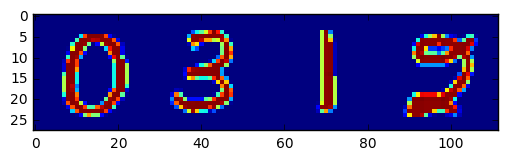

In [75]:
def concat_images(images):
    if images.shape[0] == 1:
        return np.reshape(images, (28, 28))
    return np.concatenate((np.reshape(images[0], (28,28)), concat_images(images[1:])), axis = 1)

def concat_labels(labels):
    print (labels.shape)
    print (labels[0].shape)
    if labels.shape[0] == 1:
        return labels
    return np.concatenate((labels[0], concat_labels(labels[1:])), axis = 1)

result = concat_images(images[0:4])
print (labels[0:4].flatten())
plt.imshow(result, interpolation='nearest')
plt.show()